In [1]:
%matplotlib inline
import matplotlib.pylab
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from pprint import pprint
from ConfigParser import ConfigParser
import pyodbc
import re

config = ConfigParser()
config.read('./common_stuff.ini')

['./common_stuff.ini']

### ODBC Driver
The Drill ODBC driver can be downloaded and installed by following [these instructions](https://drill.apache.org/docs/installing-the-odbc-driver/)

In [2]:
MY_DSN = """
Driver                     = /opt/mapr/drillodbc/lib/universal/libmaprdrillodbc.dylib
ConnectionType             = Zookeeper
ZKQuorum                   = se-node10:5181,se-node11:5181,se-node12:5181
ZKClusterID                = se1-drillbits
Catalog                    = DRILL
AuthenticationType         = Basic Authentication
AdvancedProperties         = CastAnyToVarchar=true
HandshakeTimeout           = 5
QueryTimeout               = 180
TimestampTZDisplayTimezone = utc
ExcludedSchemas            = sys,INFORMATION_SCHEMA
NumberOfPrefetchBuffers    = 5
"""

# Build DSN
MY_DSN = ";".join(
    [re.sub(r'(\t+|\s+)=\s+', '=', i) for i in MY_DSN.split('\n') if i != '']
)

conn = pyodbc.connect(MY_DSN, UID='cmatta', PWD=config.get('passwords', 'secluster'), autocommit=True)
cursor = conn.cursor()

## Data Source
Data was downloaded from this Reddit thread: [Full Reddit Submission Corpus now available (2006 thru August 2015)](https://www.reddit.com/r/datasets/comments/3mg812/full_reddit_submission_corpus_now_available_2006/) 

### JSON record structure
A reddit post's JSON looks like this:
```JSON
{
  "archived": true,
  "author": "literally_right_here",
  "created": 1424232991,
  "created_utc": "1424232991",
  "domain": "i.imgur.com",
  "downs": 0,
  "edited": "false",
  "gilded": 0,
  "hide_score": false,
  "id": "2w9z8x",
  "is_self": false,
  "media_embed": {},
  "name": "t3_2w9z8x",
  "num_comments": 3,
  "over_18": false,
  "permalink": "/r/aww/comments/2w9z8x/purr_fect/",
  "quarantine": false,
  "retrieved_on": 1440901058,
  "saved": false,
  "score": 193,
  "secure_media_embed": {},
  "selftext": "",
  "stickied": false,
  "subreddit": "aww",
  "subreddit_id": "t5_2qh1o",
  "thumbnail": "http://b.thumbs.redditmedia.com/SfMnSNIYBO0QUBz-xySAlSgj6ld8jsh_apjeWyrBORM.jpg",
  "title": "Purr Fect",
  "ups": 193,
  "url": "http://i.imgur.com/WiPoGb9.jpg"
}
```

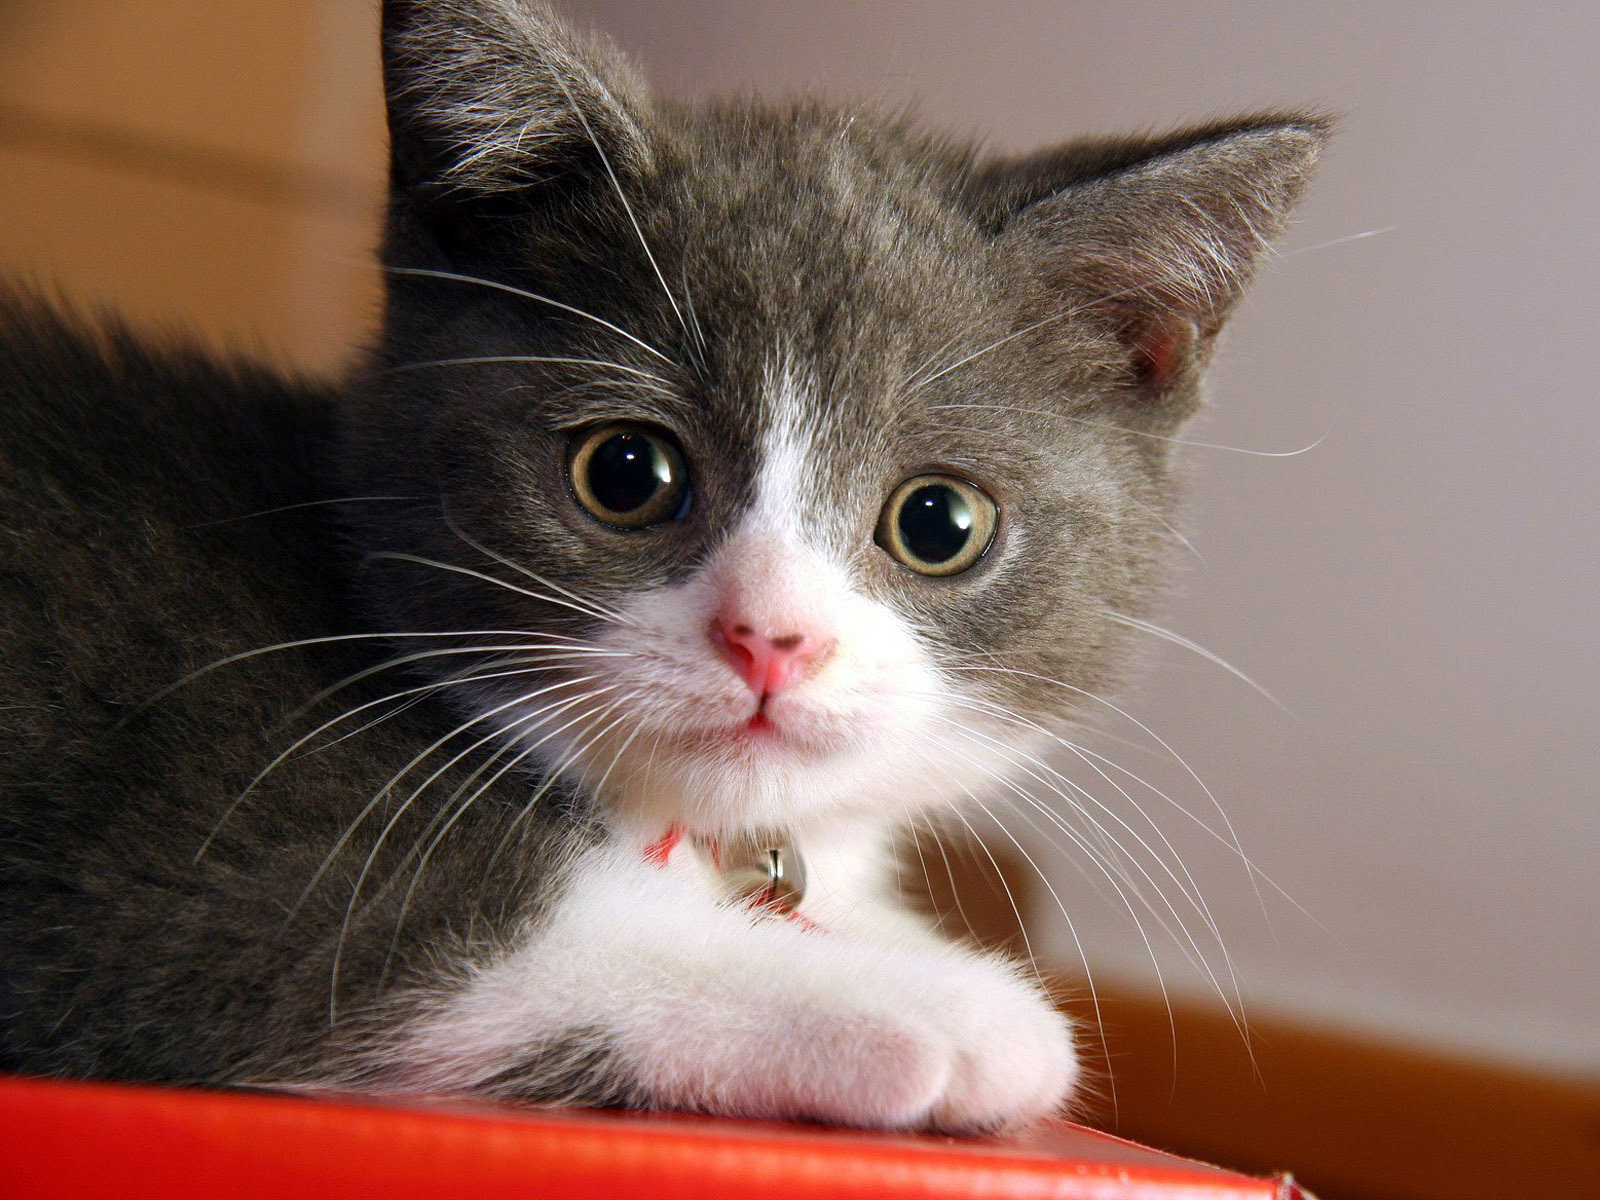

In [3]:
from IPython.display import Image
import requests
g = requests.get("http://i.imgur.com/WiPoGb9.jpg", stream=True)
g.raw.decode_content = True
Image(g.raw.data)

### Create Reddit table from JSON in Parquet:

```sql
create table `reddit/parquet/aww` partition by (`date`) as 
  SELECT `id`, 
  to_timestamp(CAST(`created_utc`AS BIGINT)) AS `posted`,
  cast(to_timestamp(CAST(`created_utc` AS BIGINT)) as date) as `date`,
  `subreddit`,
  `title`,
  `url`,
  `domain`,
  `author`,
  CAST(`over_18` as BOOLEAN) as `over_18`,
  CASE
    WHEN CHAR_LENGTH(cast(`edited` as varchar(16))) > 5
    THEN true
    ELSE `edited`
  END as `edited_bool`,
  CASE 
    WHEN CHAR_LENGTH(cast(`edited` as varchar(16))) > 5
         THEN to_timestamp(CAST(`edited` as BIGINT))
    ELSE null
  END as `edited_time`,
  CAST(`rank` AS INTEGER) AS `rank`,
  CAST(`score` AS BIGINT) AS `score`,
  CAST(`ups` AS BIGINT) AS `ups`,
  CAST(`downs` AS BIGINT) AS `downs`,
  CAST(`num_comments` AS INTEGER) AS `num_comments`,
  CAST (`is_self` AS BOOLEAN) AS `is_self`
  FROM `maprfs`.`cmatta`.`reddit/corpus_raw`;
```

In [4]:
volume_over_time_sql = """
select 
`date`,
count(`id`) as `count`
from `maprfs.cmatta`.`reddit/parquet/aww`
group by `date`
order by `date`
"""
cursor.execute(volume_over_time_sql)
volume_data = cursor.fetchall()
volume = pd.DataFrame([x[1] for x in volume_data],
                          columns=["Post Volume"],
                          index=[x[0] for x in volume_data])

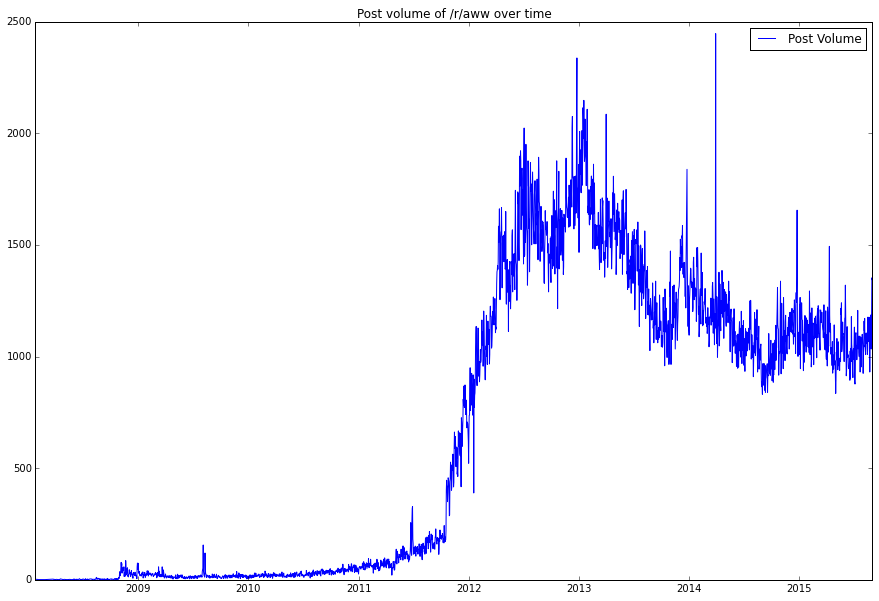

In [6]:
volume.plot(figsize=[15, 10], title="Post volume of /r/aww over time")

In [7]:
cursor.execute("""select count(`id`) from `maprfs.cmatta`.`reddit/parquet/aww`""")
cursor.fetchall()

[(1818415L, )]

In [8]:
cats_vs_dogs_sql = """
    select 
    sum(`dog`) as `dogs`,
    sum(`cat`) as `cats`, 
    `date` 
    from (
        select 1 as `dog`, 0 as `cat`, `date` from `maprfs.cmatta`.`reddit/parquet/aww`
        where `title` LIKE '%dog%'
        or `title` LIKE '%doggy%'
        or `title` LIKE '%puppy%'
        UNION ALL
        select 0 as `dog`, 1 as `cat`, `date` from `maprfs.cmatta`.`reddit/parquet/aww`
        where `title` LIKE '%cat%'
        or `title` LIKE '%kitty%'
        or `title` LIKE '%kitten%'
    ) group by `date` order by `date`"""
cursor.execute(cats_vs_dogs_sql)
cats_vs_dogs_data = cursor.fetchall()

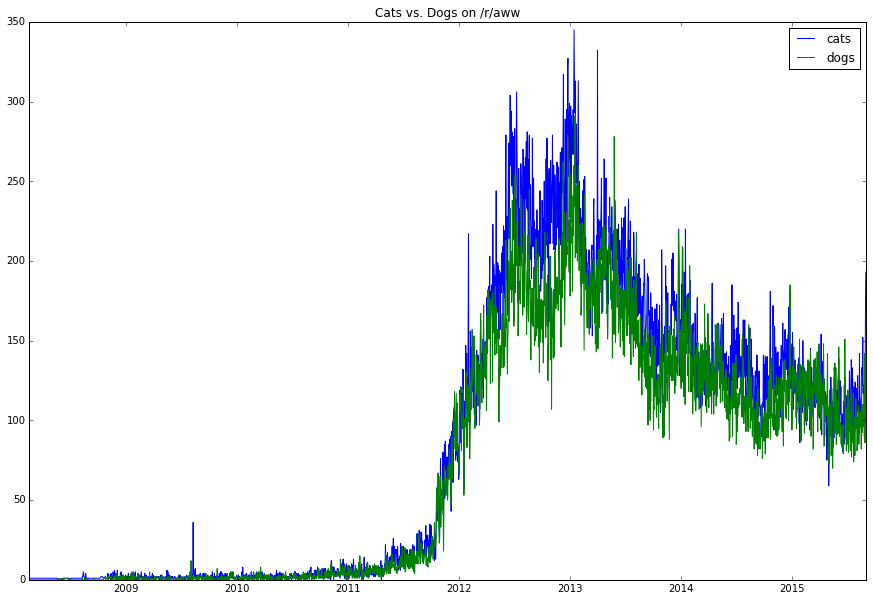

In [9]:
catsvsdogs_dataframe = pd.DataFrame({'cats': [x.cats for x in cats_vs_dogs_data],
                                     'dogs': [x.dogs for x in cats_vs_dogs_data]},
                                   index=[x.date for x in cats_vs_dogs_data])
catsvsdogs_dataframe.plot(figsize=[15, 10], title="Cats vs. Dogs on /r/aww")

In [10]:
# Reddit rank by day
reddit_rank_day_sql = """
select to_char(`posted`, 'E') as `weekday`,
count(1) as `count`
from `maprfs.cmatta`.`reddit/parquet/aww`
group by to_char(`posted`, 'E')
"""
cursor.execute(reddit_rank_day_sql)
reddit_rank_day_data = cursor.fetchall()

In [11]:
reddit_rank_day_data

[('Sat', 241340L),
 ('Wed', 262431L),
 ('Thu', 265135L),
 ('Tue', 265572L),
 ('Fri', 260023L),
 ('Mon', 269449L),
 ('Sun', 254465L)]

#### Order by days of the week (starting on Monday)
We'll use an `OrderedDict` and a reference list to order by the days of the week.

In [12]:
from collections import OrderedDict
weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
reddit_rank_day_sorted = OrderedDict(sorted(reddit_rank_day_data, key=lambda t: weekdays.index(t[0])))

#### Build the days dataframe

In [13]:
days = pd.DataFrame(
    reddit_rank_day_sorted.values(),
    columns=["Posts per day"],
    index=reddit_rank_day_sorted.keys())

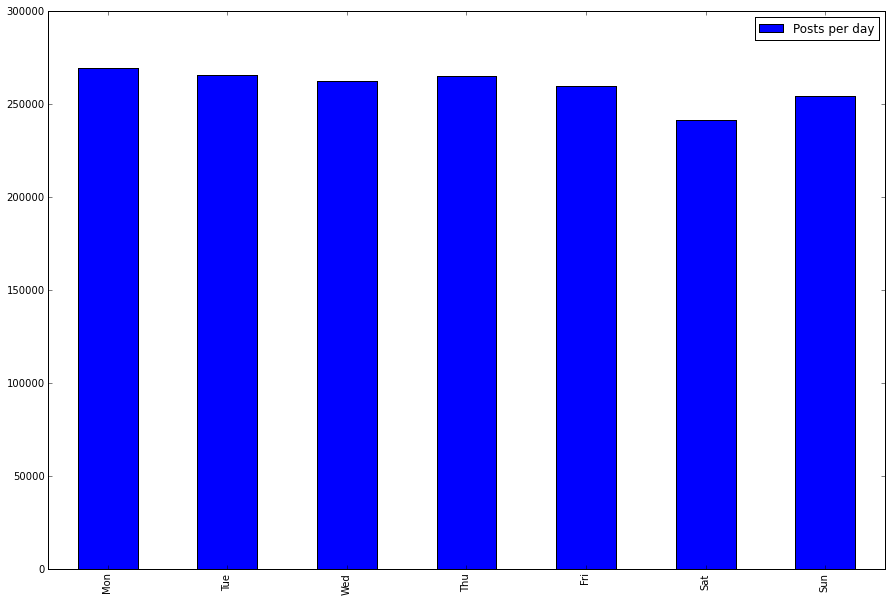

In [14]:
days.plot(kind="bar", figsize=[15, 10])

In [15]:
# Reddit Rank by Hour
reddit_rank_sql = """
select
    date_part('hour', posted) as `hour`,
    count(`id`) as `count`
from `maprfs.cmatta`.`reddit/parquet/aww`
group by date_part('hour', posted)
order by date_part('hour', posted) asc
"""
cursor.execute(reddit_rank_sql)
reddit_rank_data = cursor.fetchall()

In [16]:
len(reddit_rank_data)

24

In [17]:
# build rank data
data = {'hour': [x.hour for x in reddit_rank_data],
        'number of posts': [x.count for x in reddit_rank_data]}

In [18]:
reddit_rank_post = pd.DataFrame(data)

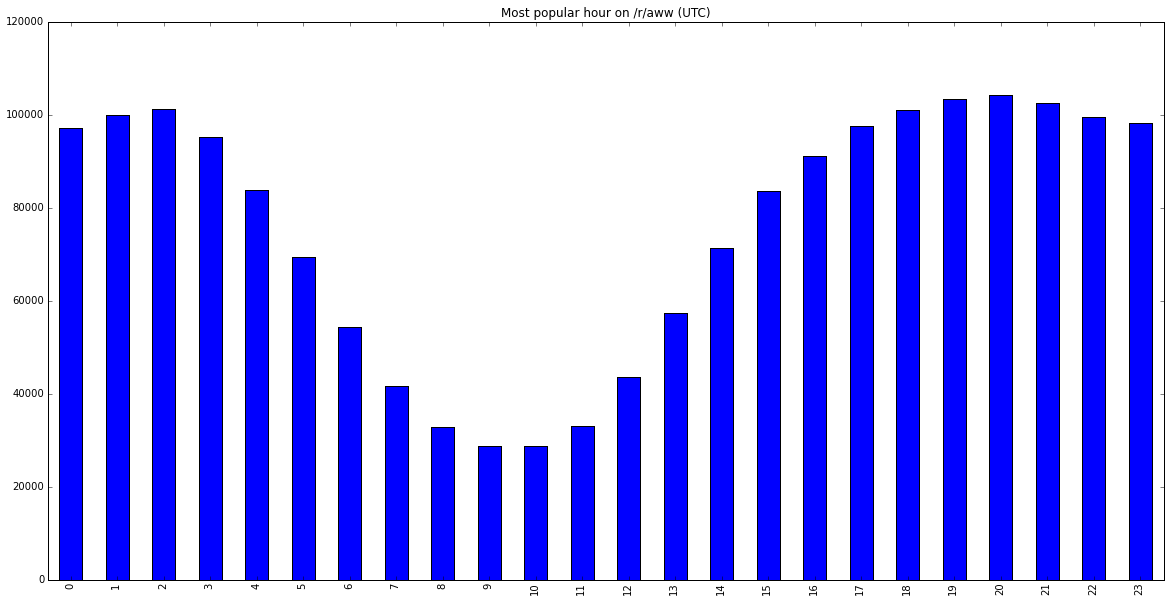

In [19]:
reddit_rank_post['number of posts'].plot(title="Most popular hour on /r/aww (UTC)", kind='bar', x='hour', figsize=(20, 10))

In [20]:
aww_ups_by_hour = """
select sum(`ups`) as `ups`,
date_part('hour', posted) as `hour`
from `maprfs.cmatta`.`reddit/parquet/aww`
group by date_part('hour', posted)
order by date_part('hour', posted) asc
"""
cursor.execute(aww_ups_by_hour)
ups_by_hour_data = cursor.fetchall()

In [21]:
ups_by_hour = pd.DataFrame({'ups': [x.ups for x in ups_by_hour_data]}, index=[x.hour for x in ups_by_hour_data])

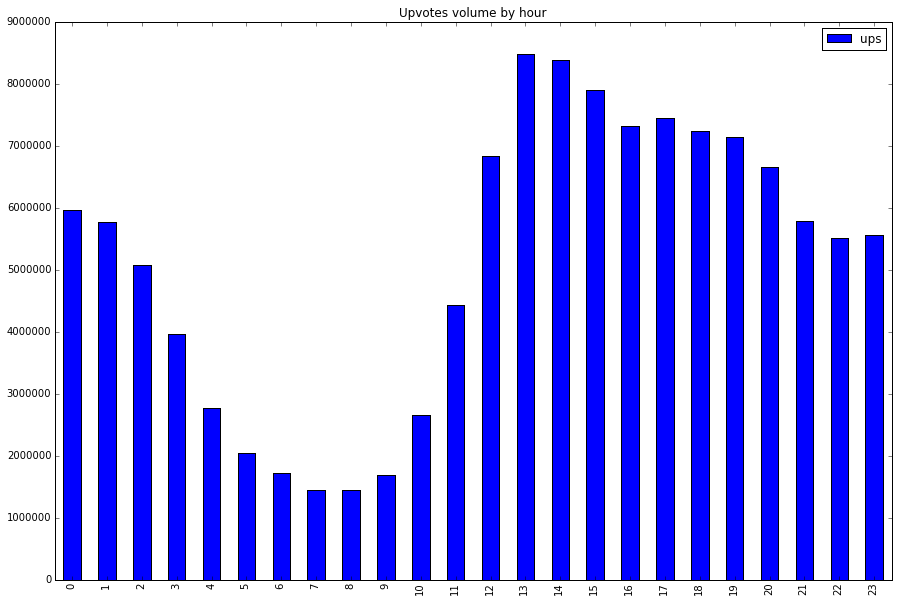

In [22]:
ups_by_hour.plot(kind='bar', figsize=[15, 10], title="Upvotes volume by hour")

In [24]:
ups_by_hour['posts'] = reddit_rank_post['number of posts']

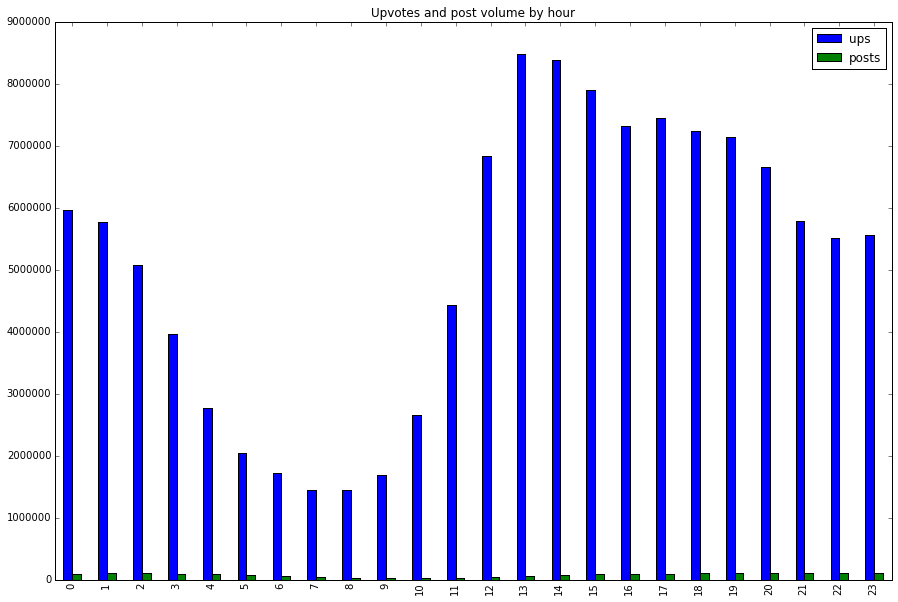

In [25]:
ups_by_hour.plot(kind='bar', figsize=[15, 10], title="Upvotes and post volume by hour")

In [27]:
ups_by_hour_scaled = ups_by_hour

In [28]:
# scale the data 
ups_by_hour_scaled = ups_by_hour
ups_by_hour_scaled -= ups_by_hour_scaled.min()
ups_by_hour_scaled /= ups_by_hour_scaled.max()

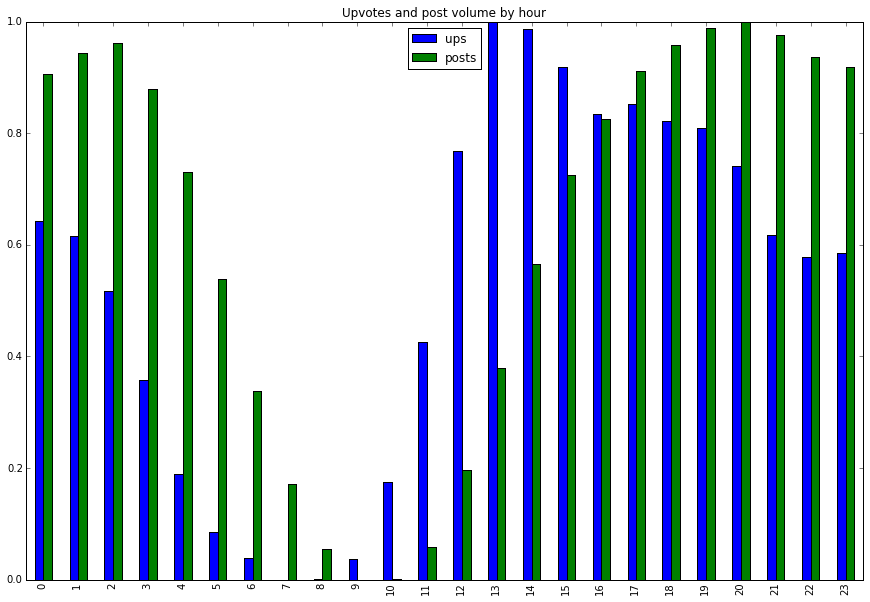

In [29]:
ups_by_hour_scaled.plot(kind='bar', figsize=[15, 10], title="Upvotes and post volume by hour")